In [27]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, block_diag
from scipy.sparse.linalg import spsolve, norm, inv, eigsh
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('text', usetex=True) # para usar latex en matplotlib

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Tomás Banduc & Cristóbal Godoy

# Laboratorio 1

**Objetivo General:** A través de esta sesión práctica, se busca que el estudiante aprenda a resolver problemas elípticos de EDP en dos-dimensiones aplicando el Método de Diferencias Finitas.

**Objetivo Particular:** Se resolverá la ecuación de Poisson en un cuadrado unitario. Además se estudiará la aproximación de su solución para condiciones de borde en dominios con curvatura, como es el caso del rectángulo perforado.

# Parte I


## Ecuación de Poisson en Dominio Cuadrado

Considere la ecuación del calor en estado estacionario sobre el cuadrado unitario:


\begin{align*}
(P)\quad\left\{
\begin{array}[c]{rll}
-\Delta u= & 0 & \text{sobre }\Omega=\left(  0,1\right)^{2}\\
u(x,0)= & 0 & \text{en }0\leq x\leq 1\\
u(x,1)= & g(x) & \text{en }0\leq x\leq 1\\
u(0,y)= & 0 & \text{en }0< y< 1\\
u(1,y)= & 0 & \text{en }0< y <1
\end{array}
\right.
\end{align*}

donde $g\in\mathcal{C}^1([0,1])$ cumple que $g(0)=g(1)=0$.

Sea $N\in\mathbb{N}$ y $\Omega_h$ el mallado equiespaciado del cuadrado unitario $\Omega$:

\begin{align*}
\Omega_{h}:=\left\{  \left(  x_{j},y_{k}\right)  \mid j,k\in\left\{
0,1,\ldots,N+1\right\}  , \quad x_j:=j\cdot h, \quad y_k:=k\cdot h \right\}
\end{align*}


Para aproximar el operador Laplaciano del problema de Poisson, se define el *Laplaciano Direcretizado* por 5 puntos como:

\begin{align*}
(\Delta_{h}U)_{j,k}=\dfrac{1}{h^{2}}\left(U_{j,k-1}+U_{j-1,k}-4U_{j,k}
+U_{j+1,k}+U_{j,k+1}
\right)
\end{align*}


Buscamos una solución $(u_{j,k})_{j,k\in\{0\,...,N+1\}}$ que cumpla la versión discretizada de $(P)$ inducida por el laplaciano anterior, de modo que $u_{j,k}\simeq u(x_j,y_k)$ para la solución única $u$ de $(P)$.


Tomando $g(x) = \sin(\pi x)$ se puede demostrar que la solución de esta ecuación está dada por:

$$u\left(  x,y\right)  =\dfrac{1}{\sinh\left(  \pi\right)}\cdot\sin\left( \pi x\right)   \sinh\left( \pi y\right) $$

### P1

> **(a)** Escriba dos funciones que calculen $\boldsymbol{A}_{h}$ y $\boldsymbol{b}_{h}$ asociadas al problema lineal equivalente del problema discreto. Las entradas para estas funciones deben ser $N$ y $g$.<br>
<br>
**(b)** Cree una función `solve` que, utilizando estas funciones, y las funciones auxiliares que necesite, entregue la solución aproximada $u_h$ del problema $(P)$.<br>
<br>
**Hint:** Le puede ser útil revisar la documentación del comando `kron` (disponible a través de `scipy.sparse`).

In [28]:
def Ah(N):
    h=1/(N + 1)
    diagonal = -4*np.ones(N) #diagonal principal
    diagonal_aux = np.ones(N - 1) #diagonal secundaria, arriba y abajo
    offset = [-1,0,1] # posiciones respecto a la diagonal en que se ubicarán los vectores
    L = diags([diagonal_aux, diagonal, diagonal_aux], offsets=offset)
    A_candidato = diags([np.ones(N*(N-1)), np.ones(N*(N-1))], offsets=[N, -N])
    A = A_candidato + block_diag([L for i in range(N)])
    return -((1/h)**2)*(A)


def bh(N,f,g):
    h=1/(N + 1)
    ran = np.arange(h, 1, h)
    dominio = np.meshgrid(ran, ran)
    b_candidato = np.vectorize(f)(dominio[0], dominio[1]).flatten()
    b_candidato[-N:] += h**(-2) * np.vectorize(g)(ran)
    return b_candidato

def solve(N, f, g):
    """ Resuelve el problema del laplaciano en 2D en (0,1)^2 con condiciones
    Dirichlet en el borde, usando una grilla uniforme de N puntos interiores, con paso h = 1/(N+1) en x e y.
    """
    return spsolve(Ah(N), bh(N, f, g))


### P2

> Resuelva la ecuación para $N\in\{10, 20, 30, 40, 50, 60, 70, ..., 100\}$, mostrando la evolución del error $L^2$ como función de $N$. Grafique la solución aproximada (en tres casos de su elección) y la solución analítica.<br> **Indicación**: Comente sus resultados.

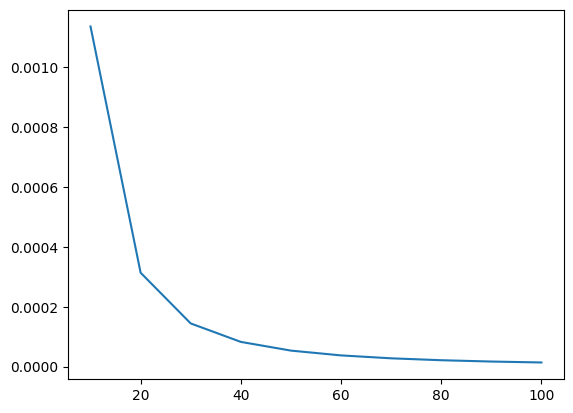

In [29]:
def sol_analitica(x, y):
    return (1/np.sinh(np.pi))*np.sin(np.pi*x)*np.sinh(np.pi*y)

def error_L2(N):
    f, g = lambda x, y: 0.0, lambda x: np.sin(np.pi*x)
    h = 1/(N+1) # N es el número de puntos interiores.
    ran = np.arange(h, 1, h)
    dom_x, dom_y = np.meshgrid(ran, ran)
    
    sol_anal = sol_analitica(dom_x, dom_y).flatten()
    sol_num = solve(N, f, g)
    sqerr_array = ((sol_anal - sol_num)**2)
    err = np.sqrt(np.sum(sqerr_array)*h**2)
    return err


N_array = np.arange(10, 110, 10)
plt.plot(N_array, np.vectorize(error_L2)(N_array))



/var/folders/66/6jrhjjpj495fxrymmpzqmsn80000gn/T/ipykernel_5813/1327738135.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


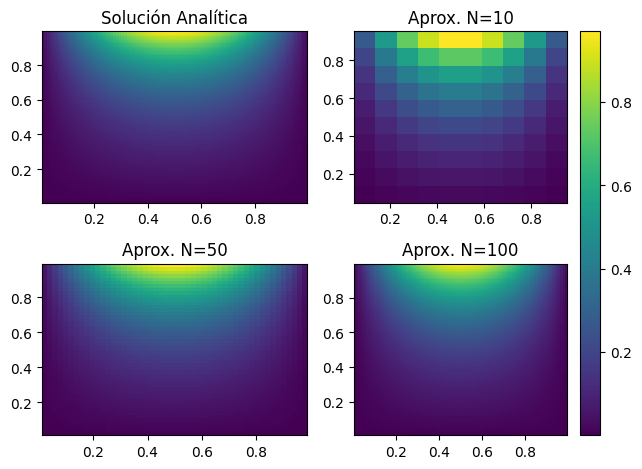

In [30]:
def generate_domains(N):
    h = 1/(N + 1)
    ran = np.arange(h, 1, h)
    return np.meshgrid(ran,ran)

f, g = lambda x, y: 0.0, lambda x: np.sin(np.pi*x)
fig = plt.figure("Solucion Analitica y Aproximada")

X_anal, Y_anal = generate_domains(100)
ax_anal = fig.add_subplot(221)
cmesh = ax_anal.pcolormesh(X_anal,Y_anal, sol_analitica(X_anal, Y_anal))
ax_anal.set_title("Solución Analítica")


X_10, Y_10 = generate_domains(10)
ax_10 = fig.add_subplot(222)
ax_10.pcolormesh(X_10, Y_10, solve(10, f, g).reshape(10, 10))
ax_10.set_title("Aprox. N=10")

X_50, Y_50 = generate_domains(50)
ax_50 = fig.add_subplot(223)
ax_50.pcolormesh(X_50, Y_50, solve(50, f, g).reshape(50, 50))
ax_50.set_title("Aprox. N=50")

X_100, Y_100 = generate_domains(100)
ax_100 = fig.add_subplot(224)
ax_100.pcolormesh(X_100, Y_100, solve(100, f, g).reshape(100, 100))
ax_100.set_title("Aprox. N=100")
fig.tight_layout()
fig.colorbar(cmesh, cax = None, ax= [ax_10, ax_100], use_gridspec=True)
fig.show()




Sean $p\in\left[  1,+\infty\right]  $ y $\boldsymbol{A}\in\mathbb{R}^{N\times N}$. Se define la norma inducida $p$ de $\boldsymbol{A}$ como:

\begin{align*}
\left\Vert \boldsymbol{A}\right\Vert _{p}=\sup\limits_{\boldsymbol{x\in}\mathbb{R}^{N}\setminus\left\{  \boldsymbol{0}\right\}  }\dfrac{\left\Vert\boldsymbol{Ax}\right\Vert _{p}}{\left\Vert \boldsymbol{x}\right\Vert_{p}}
\end{align*}

Si $\boldsymbol{A}$ es invertible, se define el número de condición en norma inducida $p$ como:

\begin{align*}\operatorname{cond}_{p}\left(  \boldsymbol{A}\right)  =\left\Vert
\boldsymbol{A}\right\Vert _{p}\left\Vert \boldsymbol{A}^{-1}\right\Vert _{p}\end{align*}

### P3
> Estudie el condicionamiento en norma $2$ de la Matriz $A_h$. En particular, determine su orden de crecimiento respecto a $N$.

**Observación:** En el caso particular de $\boldsymbol{A}_{h}$, dado que la matriz es simétrica, su número de condición en norma $2$ inducida puede calcularse mediante sus valores propios de mayor y menor magnitud:

\begin{align*}
\operatorname{cond}_{2}\left(  \boldsymbol{A}_{h}\right)  =\dfrac{\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right)  }{\lambda_{\min,h}\left(\boldsymbol{A}_{h}\right)}
\end{align*}

donde $\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right) :=\max\left\{\left\vert \lambda\right\vert \mid\lambda\in\sigma\left(  \boldsymbol{A}_{h}\right)  \right\}  $ y $\lambda_{\min,h}\left(  \boldsymbol{A}_{h}\right)
:=\min\left\{  \left\vert \lambda\right\vert \mid\lambda\in\sigma\left(\boldsymbol{A}_{h}\right)  \right\}  $.

In [31]:
def max_min_eigvals(A):
    smallest = np.abs(eigsh(A, k=1, which="SM", return_eigenvectors = False))
    largest = np.abs(eigsh(A, k=1, which="LM", return_eigenvectors = False))
    return smallest, largest

def cond_2_sparse(A):
    """
    Calcula el numero de condicionamiento en norma inducida 2
    para una matriz sparse simetrica A.
    Se obtiene como el valor propio de mayor módulo dividido por el de menor módulo

    Input:
    - A matriz sparse simetrica

    Documentacion de eigsh:
    https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.sparse.linalg.eigsh.html
    
    Nota: Debido a que eigsh no calcula todos los autovalores, decidimos usar eigh que desaprovecha que sean matrices sparse, pero da más seguridad.
    """

    max_val, min_val = max_min_eigvals(A)
    return max_val/min_val

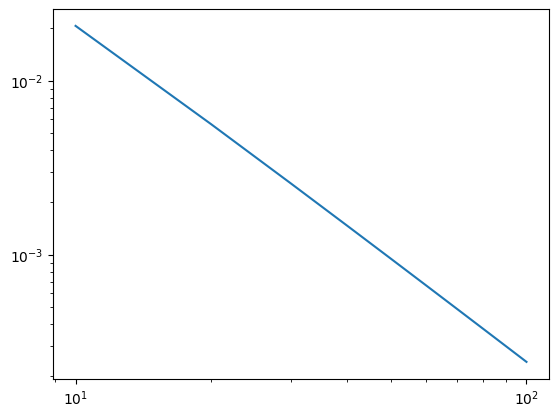

In [32]:
# def forward(x):
#     return x**(1/4)


# def inverse(x):
#     return x**4

condvals = np.vectorize(cond_2_sparse)(np.vectorize(Ah)(N_array))
plt.plot(N_array, condvals)
# plt.yscale('function', functions=(forward, inverse))
plt.yscale("log")
plt.xscale("log")

En escala log-log ebservamos una recta. Esto indixa que su dependencia as tipo ley de potencia. Podemos ajustar una ley de potencia para encontrar el exponente.

Params: [-1.87714086e+00  1.56166613e+00 -4.79969308e-05]


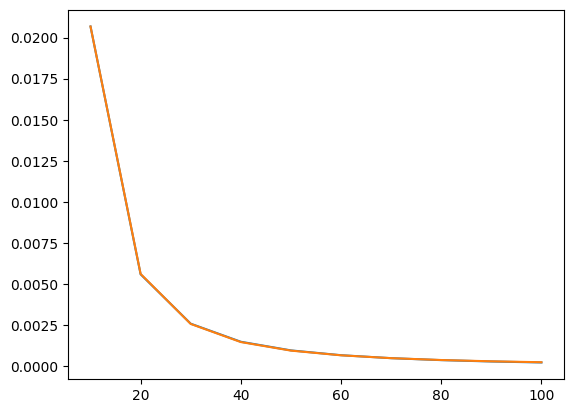

In [42]:
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

sol = curve_fit(func_powerlaw, N_array, condvals, p0 = np.asarray([-2,1,0]))
print("Params:", sol[0])
plt.plot(N_array, func_powerlaw(N_array, *sol[0]))
plt.plot(N_array, condvals)

Es un buen ajuste (disculpen los gráficos sin titulo ni ejes, pero no me alcanzó el tiempo para hacerlo). Por lo tanto podemos decir con cierta confianza que el número de condición de la matriz $A_h$ en función de N va como:

$$\operatorname{cond}_{2}\left( N \right)  \approx 1.56 N^{-1.87}$$

# Parte II

## Ecuación de Poisson en Dominio Perforado

Para $\Omega = (0, 1)^2\backslash B ((0.5, 0.5), 0.3)$, considere el siguiente problema:

\begin{align}
    \left(  P \right)  \left\{
    \begin{array}
    [c]{rl}
    -\Delta u(x,y)=&0,  & \text{si }(x,y)\text{ en }\Omega \\
    u(x,y)=&g(x,y), & \text{si} (x,y)\text{ en }\partial\Omega
    \end{array}
    \right.
\end{align}

donde $g$ viene dada por:

\begin{align*}
g\left(  x,y\right)  =\left\{
\begin{array}
[c]{rl}
2, &\text{si }(x,y) \in \partial (0,1)^2 \\
0, &\text{si }(x,y) \in \partial B ((0.5, 0.5), 0.3)
\end{array}
\right.
\end{align*}






### P1

> Programe una función que reciba un punto de la malla $(x_j , y_k)$ y entregue como resultado $1$ si es un punto interior al cual se le puede calcular $\Delta u$ con la aproximación utilizada en la fórmula de $5$ puntos, y $0$ si no.

In [47]:
def Mallado(x, y, N = 100):
  h=1/(N+1)
  r=0.3

  disN= np.sqrt((x+h-0.5)**2+(y-0.5)**2)
  disS= np.sqrt((x-h-0.5)**2+(y-0.5)**2)
  disE= np.sqrt((x-0.5)**2+(y+h-0.5)**2)
  disO= np.sqrt((x-0.5)**2+(y-h-0.5)**2)
  
  if disN < r or disS < r or disE < r or disO < r: # es parte de la malla se puede calcular la aproximacion
    return 0
  else: 
    return 1


/var/folders/66/6jrhjjpj495fxrymmpzqmsn80000gn/T/ipykernel_5813/1225191868.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


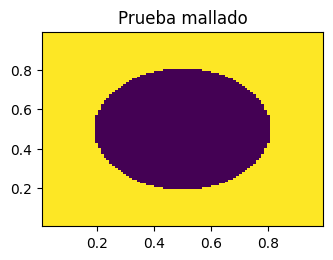

In [48]:
fig = plt.figure("Solucion Analitica y Aproximada")

X_anal, Y_anal = generate_domains(100)
ax_anal = fig.add_subplot(221)
cmesh = ax_anal.pcolormesh(X_anal,Y_anal, np.vectorize(Mallado)(X_anal, Y_anal))
ax_anal.set_title("Prueba mallado")

fig.tight_layout()
fig.colorbar(cmesh, cax = None, ax= [ax_10, ax_100], use_gridspec=True)
fig.show()




### P2

> Asuma que la matriz del sistema es de la forma $A_h = A_{h,x} + A_{h,y}$, donde $A_{h,x}$ tiene los coeficientes adecuados
para la aproximación de la derivada parcial según $x$, y $A_{h,y}$ los valores necesarios para estimar la derivada parcial en $y$. Encuentre la forma
que deben tener $A_{h,x}$ y $A_{h,y}$ y elabore funciones que calculen dichas matrices. <br> <br>
**Hint 1:** Se sugiere segmentar el problema de programación lo más posible: Puede usar las funciones auxiliares que estime convenientes.<br>
**Hint 2:** Tenga en cuenta las fórmulas explícitas de los coeficientes $\alpha,\beta$ y $\gamma$ de la interpolación del mallado vista para dominio perforado.


In [ ]:
def coefs_y(x, y, h):
    d = y_distance_to_circle(x, y)
    alpha = 2/(h**2 + h*d)
    beta = -2/(h*d)
    gamma = 2/(d**2 + h*d)
    return alpha, beta, gamma
    
def coefs_x(x,y):
    d = x_distance_to_circle(x,y)
    alpha = 2/(h**2 + h*d)
    beta = -2/(h*d)
    gamma = 2/(d**2 + h*d)
    return alpha, beta, gamma
    
    


def Ahx(N):
    h=1/(N + 1)
    diagonal = -2*np.ones(N) #diagonal principal
    diagonal_aux = np.ones(N - 1) #diagonal secundaria, arriba y abajo
    offset = [-1,0,1] # posiciones respecto a la diagonal en que se ubicarán los vectores
    L = diags([diagonal_aux, diagonal, diagonal_aux], offsets=offset)
    A = block_diag([L for i in range(N)])
    return -((1/h)**2)*(A)


def Ahy(N):
    h=1/(N + 1)
    diagonal = -2*np.ones(N) #diagonal principal
    diagonal_aux = np.zeros(N - 1) #diagonal secundaria, arriba y abajo
    offset = [-1,0,1] # posiciones respecto a la diagonal en que se ubicarán los vectores
    L = diags([diagonal_aux, diagonal, diagonal_aux], offsets=offset)
    A_candidato = diags([np.ones(N*(N-1)), np.ones(N*(N-1))], offsets=[N, -N])
    A = A_candidato + block_diag([L for i in range(N)])
    return -((1/h)**2)*(A)

### P3
> Escriba una función que calcule $b_h$ adaptado a este caso.

In [35]:
def bh(N):


    return b

### P4
>Resuelva el sistema $A_h u_h = b_h$ asociado a la discretización del dominio perforado, grafique la solución aproximada para $N\in\{10, 20, 30, 40, 50\}$.
<br> **Indicación:** Comente sus resultados.

In [36]:
def solve2(N):

    return

### P5
>Muestre qué sucede con el condicionamiento de la matriz utilizando la fórmula de valores propios de la Parte I. ¿Es dicha fórmula válida en este caso? ¿Cómo adaptaría su código para $f\neq 0$?